In [10]:
def subsetter(arrayWithIndex,whichIndex):
    return[arrayWithIndex.index[i][whichIndex] for i in range(len(arrayWithIndex.index))]

In [1]:
#96696 .... done2
#97703 .... no
#85937 .... no
#85253 .... done2.... but a little too good
#103493 ... done2... actually, all are a little too good
#98481 .... yes..... but clearly a subset of the population.... doneso2
#81333 ... yes done2
# 105187... looks a little too good... can't get a 180 on it
#93773 .... no


import numpy as np
import re
import nltk
from sklearn.datasets import load_files
#nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords


import pyodbc
dbhandle = pyodbc.connect('DRIVER={SQL Server};SERVER=146.20.65.83;DATABASE=Sandbox;UID=sa;PWD=Quantum!00')

#Get the data from the database
import pandas
df = pandas.read_sql("select PlatformUserID,cycleid,organizationid,questionid,questiontext,response,codetext,OriginDB,substring(convert(varchar,DateCreated,21),0,11) as DateCreated,HireDate,TermDate from sandbox..withinClientTurnoverEligiblePartial where (tenureterm > 0 or hiretonow > 0) and organizationid = 98487",dbhandle)
#df = pandas.read_sql("select PlatformUserID,cycleid,organizationid,questionid,questiontext,response,codetext,OriginDB,substring(convert(varchar,DateCreated,21),0,11) as DateCreated,HireDate,TermDate from sandbox..withinClientTurnoverEligiblePartial where organizationid = 98481",dbhandle)

##### Now I need to find everyone who is still active and has been there for more than 90 days, and their datars

stillActiveDatars = pandas.read_sql("select PlatformUserID,cycleid,organizationid,questionid,questiontext,response,codetext,OriginDB,substring(convert(varchar,DateCreated,21),0,11) as DateCreated,HireDate,TermDate from sandbox..withinClientTurnoverEligibleComplete where (getDate() < termDate or termdate is null) and  (tenureterm > 0 or hiretonow > 0) and organizationid = 98487",dbhandle)
#stillActiveDatars = pandas.read_sql("select PlatformUserID,cycleid,organizationid,questionid,questiontext,response,codetext,OriginDB,substring(convert(varchar,DateCreated,21),0,11) as DateCreated,HireDate,TermDate from sandbox..withinClientTurnoverEligibleComplete where (getDate() < termDate or termdate is null) and organizationid = 98481",dbhandle)



In [2]:
df.shape

(560657, 11)

In [3]:
surveys = df[df['questiontext'] == 'numberSurveys']
surveys['response'] = pandas.to_numeric(surveys['response'])
surveys1 = df[df['questiontext'] == 'numberSurveys']
surveys1['response'] = pandas.to_numeric(surveys1['response'])
surveys2 = df[df['questiontext'] == 'numberSurveys']
surveys2['response'] = pandas.to_numeric(surveys2['response'])

surveys['response'] = np.where(surveys['response'] == 0, 0, 1)
surveys['questiontext'] = 'has_taken_survey'

#Percentile
surveys1['response'] = pandas.qcut(surveys1.response.rank(method='first'),100, labels=False,duplicates='drop')
surveys1['questiontext'] = 'surveyPercentile'

#Quartile
surveys2['response'] = pandas.qcut(surveys2.response.rank(method='first'),4, labels=False,duplicates='drop')
surveys2['questiontext'] = 'surveyQuartile'

#Concat these then stick them back in df
surveyDFS = [surveys,surveys1,surveys2,df]
df = pandas.concat(surveyDFS, ignore_index=True)


C:\Users\BobKill\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\BobKill\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\BobKill\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [4]:
import datetime
import string
stillActiveDatars['questiontext'] = stillActiveDatars['questiontext'].str.replace('[{}]'.format(string.punctuation), '')
stillActiveDatars['questiontext'] = stillActiveDatars['questiontext'].replace(' ', '_', regex=True)
stillActiveDatars['varField'] =  stillActiveDatars['questiontext'].astype(str) + '_' + stillActiveDatars['response'].astype(str)

formatDateCreate = []
for d in np.arange(0,stillActiveDatars.shape[0]):
    stringit = str(stillActiveDatars['DateCreated'][d])[0:10]
    formatDateCreateTemp = datetime.datetime.strptime(stringit, '%Y-%m-%d')
    formatDateCreate.append(formatDateCreateTemp)

stillActiveDatars['DateCreated'] = formatDateCreate
stillActiveDatars2 = stillActiveDatars[~stillActiveDatars['response'].isin(['0','0.0000'])]    
    


In [5]:

df['questiontext'] = df['questiontext'].str.replace('[{}]'.format(string.punctuation), '')
df['questiontext'] = df['questiontext'].replace(' ', '_', regex=True)
df['varField'] =  df['questiontext'].astype(str) + '_' + df['response'].astype(str)


formatTermDate = []
for td in np.arange(0,df.shape[0]):
    formatTermDateTemp = np.where(pandas.isnull(df['TermDate'][td]), '2099-12-31', df['TermDate'][td])
    formatTermDateTemp = str(formatTermDateTemp)[0:10]
    formatTermDate.append(formatTermDateTemp)
    
df['formatTermDate'] = formatTermDate

import datetime
formatDateAgain = []
for d in np.arange(0,df.shape[0]):
    formatDateAgainTemp = datetime.datetime.strptime(df['formatTermDate'][d], '%Y-%m-%d')
    formatDateAgain.append(formatDateAgainTemp)

formatDateCreate = []
for d in np.arange(0,df.shape[0]):
    stringit = str(df['DateCreated'][d])[0:10]
    formatDateCreateTemp = datetime.datetime.strptime(stringit, '%Y-%m-%d')
    formatDateCreate.append(formatDateCreateTemp)

In [6]:
df['DateCreated'] = formatDateCreate
df['TerminationDate'] = formatDateAgain

terminate = []
for t in np.arange(0,df.shape[0]):
    termTemp = np.where((df['TerminationDate'][t] - df['DateCreated'][t]).days < 90,1,0)
    terminate.append(termTemp)

df['term'] = terminate

df['term'] = pandas.array(df['term'].tolist())



In [7]:
stillActiveDatarsWide = stillActiveDatars.pivot_table(index=['PlatformUserID'],columns='varField',values='response',aggfunc='count',fill_value = 0)
stillActiveDatarsWide['PlatformUserID'] = stillActiveDatarsWide.index
stillActiveDatarsWide['term'] = 3 #So we can include it in the training set, later

In [8]:
df2 = df[~df['response'].isin(['0','0.0000'])]
wide = df2.pivot_table(index=['PlatformUserID','term'],columns='varField',values='response',aggfunc='count',fill_value = 0)


In [11]:
wide['PlatformUserID'] = subsetter(wide,0)
wide['term'] = subsetter(wide,1)
wide.index.names=['firstInd','secondInd']

In [12]:
countCatStage = pandas.DataFrame(wide.groupby('term')['PlatformUserID'].count())
countCatStage['term'] = countCatStage.index
countCatStage.columns = ['count','term']

maxCatCount = countCatStage['count'].max()

replicatesRequired = []
for x in countCatStage['count']:
    a = maxCatCount - x
    replicatesRequired.append(a)
    
countCatStage['replicatesRequired'] = replicatesRequired


#Create counter equal to the number of themes currently used
ind = np.arange(len(countCatStage.index))

#Create empty pandas dataframe
replicatedDataset = pandas.DataFrame()


for i in ind:
    #subset temporary dataframe with themename == ith element of 
    tempdf = wide[wide.term == countCatStage['term'][i]]
    sampledSet = tempdf.sample(countCatStage['replicatesRequired'][i],replace=True)
    replicatedDataset = replicatedDataset.append(sampledSet)


    
wide2 = wide.append(replicatedDataset)  
wide2 = wide2.reset_index(drop=True)

#What data are allowed in the training dataset (only use data I currently have access to)?

wide2_allowed = wide2.columns[wide2.columns.isin(stillActiveDatarsWide.columns)]

wide2 = wide2[wide2_allowed]

#Keep the indices of the data splits for later
X,y,indices = wide2.drop(['PlatformUserID','term'], axis=1), wide2.term,range(wide2['term'].count())

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train,indices_test = train_test_split(X, y, indices, test_size=0.4, random_state=0)
X_validate, X_test, y_validate, y_test, indices_validate,indices_test = train_test_split(X_test, y_test, indices_test, test_size=0.5, random_state=0)


In [14]:
df.shape

(571235, 15)

In [15]:

from keras.models import Sequential
from keras import layers
from keras.layers import Activation, Dense, Dropout

model = Sequential()
model.add(Dense(2, input_dim=X.shape[1], activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_validate, y_validate),
                    batch_size=30)

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 8832      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                90        
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
___________________________________________________________

In [16]:
#Check to see accuracy and loss through epochs (backpropagation iterations)

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

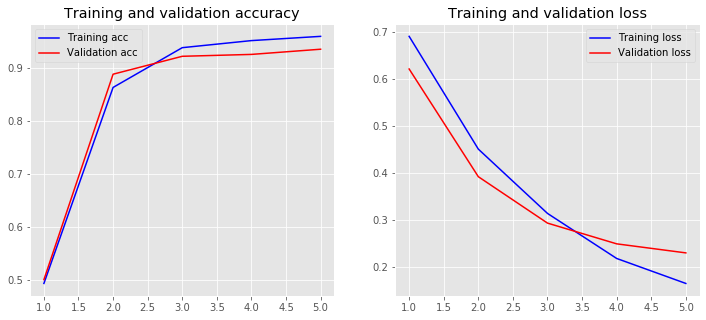

In [17]:
plot_history(history)



In [18]:
y_validateThreshpred = pandas.DataFrame(model.predict(X_validate))
y_validateThresh = pandas.DataFrame(y_validate)
y_validateThresh.index = range(0,y_validateThresh.shape[0])


In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

foobar = pandas.concat([y_validateThreshpred,y_validateThresh], axis=1, ignore_index=True)
foobar.columns = ['predProb','actual']
foobar['pred'] = [1 if f >= 0.7 else 0 for f in foobar['predProb']]
print(confusion_matrix(foobar['actual'],foobar['pred']))
print(classification_report(foobar['actual'],foobar['pred']))

[[522  40]
 [ 48 514]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       562
           1       0.93      0.91      0.92       562

    accuracy                           0.92      1124
   macro avg       0.92      0.92      0.92      1124
weighted avg       0.92      0.92      0.92      1124



In [23]:
#Final evaluation... must match threshold set above
y_pred = pandas.DataFrame(model.predict(X_test))
y_actual = pandas.DataFrame(y_test)
y_actual.index = range(0,y_actual.shape[0])

foobar = pandas.concat([y_pred,y_actual], axis=1, ignore_index=True)
foobar.columns = ['predProb','actual']
foobar['pred'] = [1 if f >= 0.7 else 0 for f in foobar['predProb']]

print(confusion_matrix(foobar['actual'],foobar['pred']))
print(classification_report(foobar['actual'],foobar['pred']))

[[524  32]
 [ 54 514]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       556
           1       0.94      0.90      0.92       568

    accuracy                           0.92      1124
   macro avg       0.92      0.92      0.92      1124
weighted avg       0.92      0.92      0.92      1124



In [24]:
maxDateCreated = pandas.DataFrame(stillActiveDatars.groupby('PlatformUserID')['DateCreated'].max())
maxDateCreated['UserID'] = maxDateCreated.index

maxCycleID = pandas.DataFrame(stillActiveDatars.groupby('PlatformUserID')['cycleid'].max())
maxCycleID['UserID2'] = maxCycleID.index

In [25]:
stillActiveDatarsWideFinalColumns = stillActiveDatarsWide.columns[stillActiveDatarsWide.columns.isin(X_train.columns)]
stillActiveDatarsWideFinal = stillActiveDatarsWide[stillActiveDatarsWideFinalColumns]
y_pred = pandas.DataFrame(model.predict(stillActiveDatarsWideFinal))
y_pred['predictionProb'] = pandas.DataFrame(model.predict(stillActiveDatarsWideFinal))
y_pred['Prediction'] = [1 if f >= 0.7 else 0 for f in y_pred['predictionProb']]
y_pred['PlatformUserID'] = stillActiveDatarsWide['PlatformUserID'].tolist()
y_pred['OrganizationID'] = 105187
y_pred = y_pred.merge(maxDateCreated, left_on='PlatformUserID',right_on='UserID')
y_pred = y_pred.merge(maxCycleID, left_on='PlatformUserID',right_on='UserID2')
y_pred['RowUpdateDate'] = pandas.Timestamp('today').strftime('%Y-%m-%d')
y_pred['PredictionWindow'] = 90
y_pred['TypeOfPrediction'] = 'Binary'
y_pred['ExcludeLowTenureValue'] = 180
from datetime import datetime, timedelta
y_pred = y_pred[y_pred['DateCreated'] > (datetime.today() - timedelta(days=90))]


In [27]:
#Check how many predicted yes and how many no

y_pred.groupby('Prediction')['PlatformUserID'].count()


Prediction
0    1312
1     238
Name: PlatformUserID, dtype: int64

In [507]:
y_predFinal = y_pred[['PlatformUserID','OrganizationID','DateCreated','PredictionWindow','TypeOfPrediction','Prediction','cycleid','RowUpdateDate','ExcludeLowTenureValue']]
y_predFinal.rename(columns = {'DateCreated':'PredictionFromDate','cycleid':'AsOfCycleID'},inplace=True)

C:\Users\BobKill\Anaconda3\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [508]:
y_predFinal[y_predFinal['Prediction']==1]


,PlatformUserID,OrganizationID,PredictionFromDate,PredictionWindow,TypeOfPrediction,Prediction,AsOfCycleID,RowUpdateDate,ExcludeLowTenureValue
13,0157EBB2-2AE5-427D-A9B4-AA394ABDF4CF,105187,2019-10-22,90,Binary,1,38180,2020-01-08,180
232,2DC6C106-B521-4974-BE4D-DDE26B119FEF,105187,2019-11-22,90,Binary,1,39482,2020-01-08,180
713,80B59A96-B9C1-48DF-83B0-3338CA8633E7,105187,2019-11-22,90,Binary,1,39482,2020-01-08,180
771,88B7EBAE-383A-4700-8EF1-2980241D24C5,105187,2019-11-23,90,Binary,1,39482,2020-01-08,180
844,958846D1-D26A-4CC8-9809-07942BDEA8DF,105187,2019-12-01,90,Binary,1,40687,2020-01-08,180
907,A09E6A67-6A03-4F64-8B6A-556866C28476,105187,2019-11-02,90,Binary,1,22675379,2020-01-08,180
1303,E9FBD334-F85D-4C5A-94DF-CA12E359E4E6,105187,2019-10-30,90,Binary,1,38180,2020-01-08,180
1332,EDD3F8F1-58DD-4556-8A22-930911E0AFBD,105187,2019-11-04,90,Binary,1,38180,2020-01-08,180


In [522]:
# To insert data frame into MS SQL database without iterate the data-frame
import sqlalchemy
from sqlalchemy import create_engine, MetaData, Table, select
from six.moves import urllib
params = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=146.20.65.83;DATABASE=Sandbox;UID=sa;PWD=Quantum!00")
engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params) 
engine.connect() 
# suppose df is the data-frame that we want to insert in database
y_predFinal.to_sql(name='turnoverPrediction',con=engine, index=False, if_exists='append')


In [383]:
foobar = wide[wide['numberSurveys_1'] ==1]
foobar.head()

,varField,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,At_Valet_Living_we_do_things_efficiently_and_well_1,At_Valet_Living_we_do_things_efficiently_and_well_2,At_Valet_Living_we_do_things_efficiently_and_well_3,...,When_the_organization_makes_changes_I_understand_why_1,When_the_organization_makes_changes_I_understand_why_2,When_the_organization_makes_changes_I_understand_why_3,When_the_organization_makes_changes_I_understand_why_4,When_the_organization_makes_changes_I_understand_why_5,When_the_organization_makes_changes_I_understand_why_6,numberSurveys_1,numberSurveys_2,PlatformUserID,term
firstInd,secondInd,,,,,,,,,,,,,,,,,,,,,
00B9B653-E0C6-4E7C-8ED7-D63EA36769AF,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,00B9B653-E0C6-4E7C-8ED7-D63EA36769AF,1
00DB4395-8109-4C4B-87B0-1F7B4D556BFE,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,00DB4395-8109-4C4B-87B0-1F7B4D556BFE,1
029053B2-ED03-4BFF-85EA-392A6ECAB9B8,1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,029053B2-ED03-4BFF-85EA-392A6ECAB9B8,1
02F77577-14C0-47C1-AE84-778572B8CC74,1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,02F77577-14C0-47C1-AE84-778572B8CC74,1
03CB96C2-0943-42E5-A30C-D9CCB9F67BA6,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,03CB96C2-0943-42E5-A30C-D9CCB9F67BA6,1
